# Вебинар 2. Бейзлайны и детерминированные алгоритмы item-item

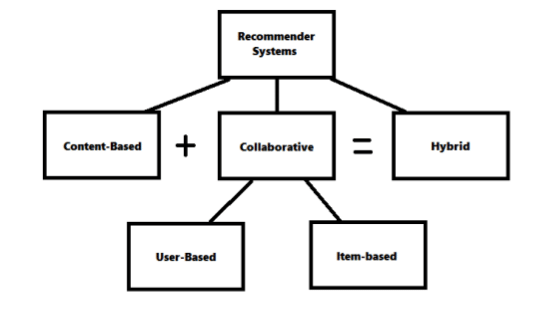

In [1]:
# !pip install implicit

[Implicit](https://implicit.readthedocs.io/en/latest/quickstart.html) - очень быстрая и 
эффективная библиотека для рекоммендаций

Основные фичи:
    - Cython под капотом - высокая скорость
    - Множество приближенных алгоритмов - быстрее, чем оригинальные
    - Содежрит большинство популярных алгоритмов
    - Есть алгоритмы ранжирования
    - Поиск похожих товаров / юзеров
    - Есть возможность пересчета "холодного" юзера "на лету"
    - Возможность фильтровать товары при рекомендациях (Например, не рекомендовать женские товары мужчинам)
    - Есть метрики качества

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender
# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

In [2]:
data = pd.read_csv('../data/retail_train.csv')
# data_index = data.index.to_numpy()
# np.random.shuffle(data_index)
# data_index = data_index[:round(data_index.shape[0] * 0.01)]
# data = data.iloc[data_index]
data.head(2)

user_id    basket_id  day    item_id  quantity  sales_value  store_id  \
0     2375  26984851472  1.0  1004906.0       1.0         1.39     364.0   
1     2375  26984851472  1.0  1033142.0       1.0         0.82     364.0   

   retail_disc  trans_time  week_no  coupon_disc  coupon_match_disc  
0         -0.6      1631.0      1.0          0.0                0.0  
1          0.0      1631.0      1.0          0.0                0.0

In [3]:
data['week_no'].nunique()

36

In [4]:
users, items, interactions = data.user_id.nunique(), data.item_id.nunique(), data.shape[0]

print('# users: ', users)
print('# items: ', items)
print('# interactions: ', interactions)

# users:  2496
# items:  51916
# interactions:  748087


In [5]:
popularity = data.groupby('item_id')['sales_value'].sum().reset_index()
popularity.describe()

item_id   sales_value
count  5.191600e+04  5.191600e+04
mean   3.402942e+06  1.342784e+03
std    3.719560e+06  2.964305e+05
min    2.567100e+04  0.000000e+00
25%    9.337265e+05  3.490000e+00
50%    1.081330e+06  9.590000e+00
75%    6.514091e+06  3.031000e+01
max    1.300340e+07  6.754185e+07

In [6]:
popularity = data.groupby('item_id')['user_id'].nunique().reset_index()
popularity.describe()

item_id       user_id
count  5.191600e+04  51916.000000
mean   3.402942e+06      9.416981
std    3.719560e+06     27.918281
min    2.567100e+04      1.000000
25%    9.337265e+05      1.000000
50%    1.081330e+06      2.000000
75%    6.514091e+06      8.000000
max    1.300340e+07   1535.000000

**Note:**  
Еще есть данные по характеристикам товаров и пользователей. Они нам пригодятся через несколько вебинаров

In [7]:
item_features = pd.read_csv('../data/product.csv')
item_features.head(2)

PRODUCT_ID  MANUFACTURER    DEPARTMENT     BRAND            COMMODITY_DESC  \
0       25671             2       GROCERY  National                  FRZN ICE   
1       26081             2  MISC. TRANS.  National  NO COMMODITY DESCRIPTION   

            SUB_COMMODITY_DESC CURR_SIZE_OF_PRODUCT  
0          ICE - CRUSHED/CUBED                22 LB  
1  NO SUBCOMMODITY DESCRIPTION

In [8]:
user_features = pd.read_csv('../data/hh_demographic.csv')
user_features.head(2)

AGE_DESC MARITAL_STATUS_CODE INCOME_DESC HOMEOWNER_DESC      HH_COMP_DESC  \
0      65+                   A      35-49K      Homeowner  2 Adults No Kids   
1    45-54                   A      50-74K      Homeowner  2 Adults No Kids   

  HOUSEHOLD_SIZE_DESC KID_CATEGORY_DESC  household_key  
0                   2      None/Unknown              1  
1                   2      None/Unknown              7

### Train-test split

В рекомендательных системах корректнее использовать train-test split по времени, а не случайно  
Я возьму последние 3 недели в качестве теста

In [9]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

In [10]:
data_train.shape[0], data_test.shape[0]

(624033, 90699)

# 1. Бейзлайны

Создадим датафрейм с покупками юзеров на тестовом датасете (последние 3 недели)

In [11]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

user_id                                             actual
0        1  [834631.0, 852662.0, 853529.0, 855488.0, 85694...
1        2  [831125.0, 834465.0, 882496.0, 892603.0, 91612...

In [12]:
test_users = result.shape[0]
new_test_users = len(set(data_test['user_id']) - set(data_train['user_id']))

print('В тестовом дата сете {} юзеров'.format(test_users))
print('В тестовом дата сете {} новых юзеров'.format(new_test_users))

В тестовом дата сете 1897 юзеров
В тестовом дата сете 0 новых юзеров


### 1.1 Random recommendation

In [13]:
def random_recommendation(items, n=5):
    """Случайные рекоммендации"""
    
    items = np.array(items)
    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()

In [14]:
%%time

items = data_train.item_id.unique()

result['random_recommendation'] = result['user_id'].apply(lambda x: random_recommendation(items, n=5))
result.head(2)

CPU times: user 1.15 s, sys: 1.12 ms, total: 1.15 s
Wall time: 1.15 s


user_id                                             actual  \
0        1  [834631.0, 852662.0, 853529.0, 855488.0, 85694...   
1        2  [831125.0, 834465.0, 882496.0, 892603.0, 91612...   

                               random_recommendation  
0  [910968.0, 9337751.0, 819765.0, 1027216.0, 844...  
1  [9550431.0, 900886.0, 819868.0, 1088877.0, 112...

### 1.2 Popularity-based recommendation

In [15]:
def popularity_recommendation(data, n=5):
    """Топ-n популярных товаров"""
    
    popular = data.groupby('item_id')['sales_value'].sum().reset_index()
    popular.sort_values('sales_value', ascending=False, inplace=True)
    
    recs = popular.head(n).item_id
    
    return recs.tolist()

In [16]:
%%time

# Можно так делать, так как рекомендация не зависит от юзера
popular_recs = popularity_recommendation(data_train, n=5)

result['popular_recommendation'] = result['user_id'].apply(lambda x: popular_recs)
result.head(2)

CPU times: user 33.6 ms, sys: 166 µs, total: 33.8 ms
Wall time: 33.1 ms


user_id                                             actual  \
0        1  [834631.0, 852662.0, 853529.0, 855488.0, 85694...   
1        2  [831125.0, 834465.0, 882496.0, 892603.0, 91612...   

                               random_recommendation  \
0  [910968.0, 9337751.0, 819765.0, 1027216.0, 844...   
1  [9550431.0, 900886.0, 819868.0, 1088877.0, 112...   

                              popular_recommendation  
0  [6534178.0, 1029743.0, 6533889.0, 916122.0, 65...  
1  [6534178.0, 1029743.0, 6533889.0, 916122.0, 65...

### 1.3 Weighted random recommender

- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)

*Пример*  
item_1 - 5, item_2 - 7, item_3 - 4  # / sum  
item_1 - 5 / 16, item_2 - 7 / 16, item_3 - 4 / 16

In [17]:
def weighted_random_recommendation(items_weights, n=5):
    """Случайные рекоммендации
    
    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
    """
    
    # Подсказка: необходимо модифицировать функцию random_recommendation()
    # your_code
    
    return recs.tolist()

In [18]:
%%time

# your_code

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs


### Выводы по бейзлайнам
- Фиксируют базовое качество;
- Бейзлайны могут быть фильтрами;
- Иногда бейзлайны лучше ML-модели

# 2. Детерминированные алгоритмы item-item

## 2.1 Item-Item Recommender / ItemKNN

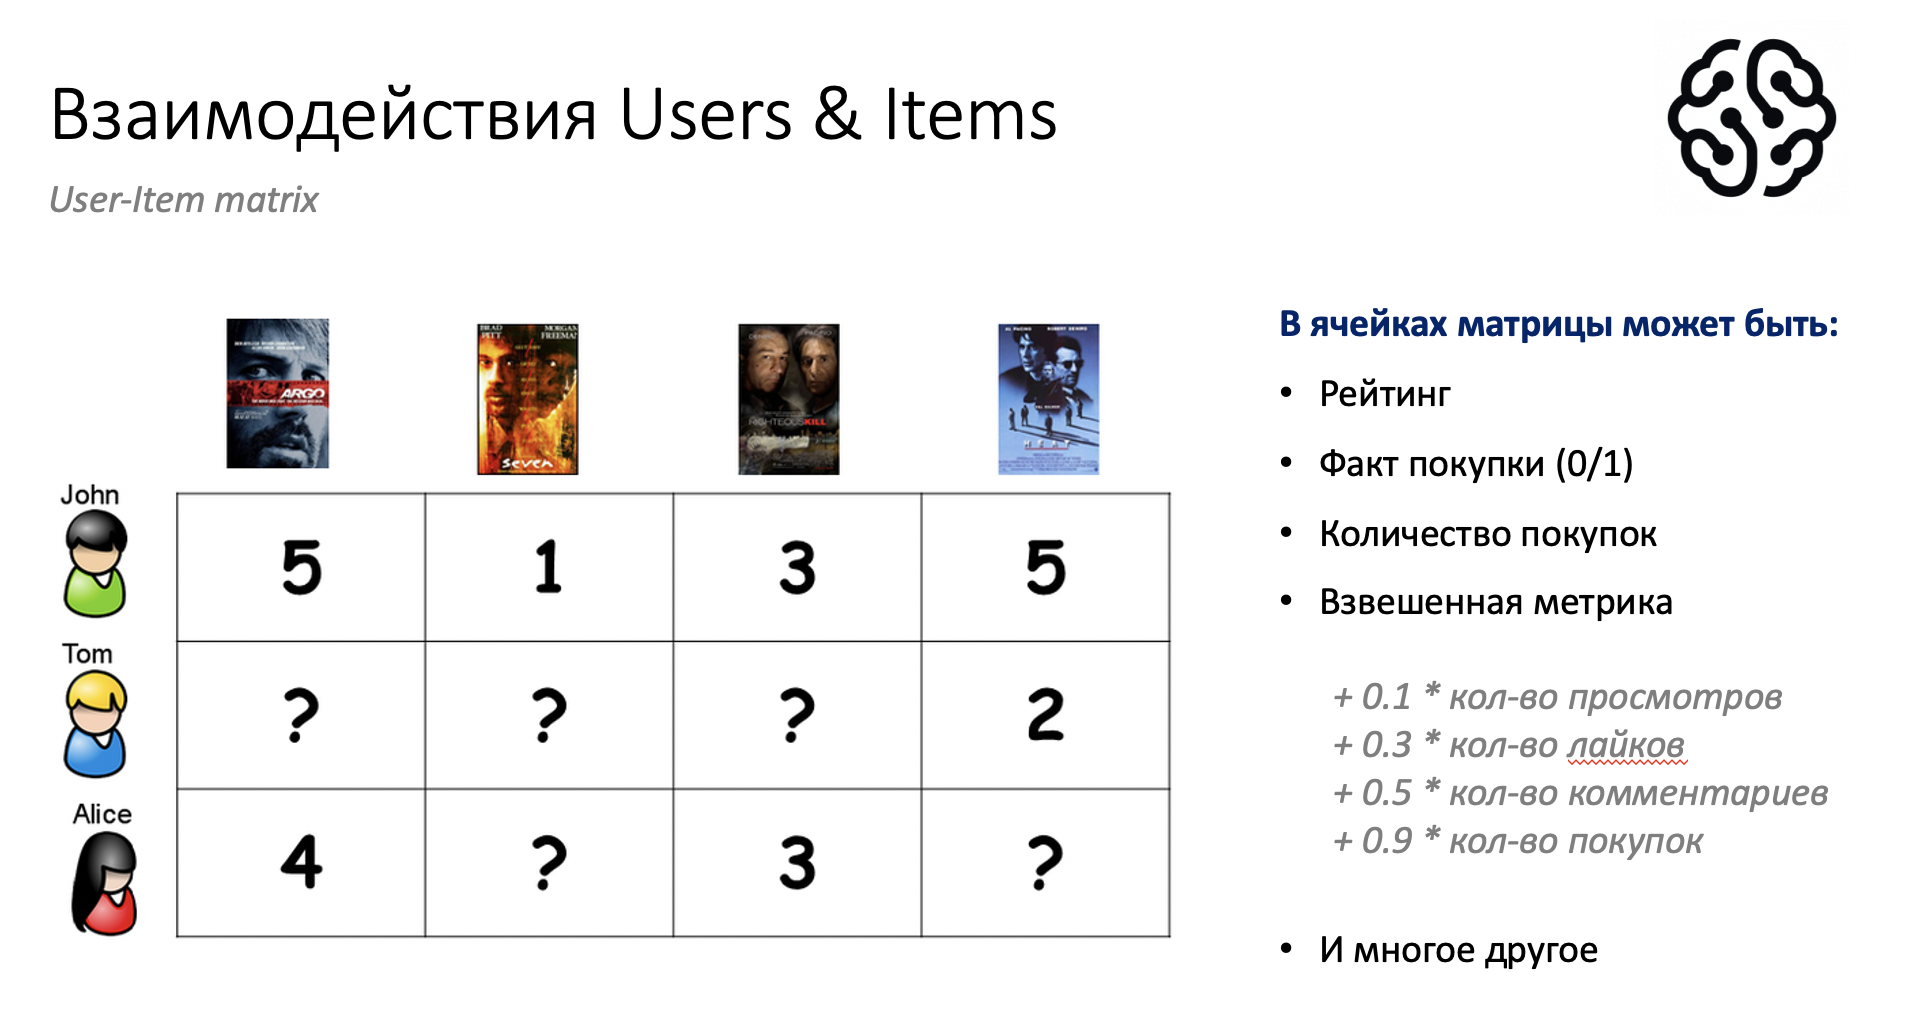

То, что именно находится в матрице user-item нужно определять из бизнес-логики

Варианты для нашего датасета(не исчерпывающий список):
    - Факт покупки (0 / 1)
    - Кол-во покупок (count)
    - Сумма покупки, руб
    - ...
    
**Детерминированные алгоритмы**:
    - Предсказывают те числа, которые стоят в матрице

**ML-алгоритмы (большинство)**:
    - В качестве *таргетов* "под капотом" принимают 0 и 1 (в ячейке не 0 -> таргет 1)
    - А абсолютные значения воспринимают как *веса ошибок*
    
*P.S.* На самом деле есть много трюков, как можно заполнять матрицу user-item. Об этом мы поговорим на следующих вебинарах

**Как работает Item-Item Recommender**

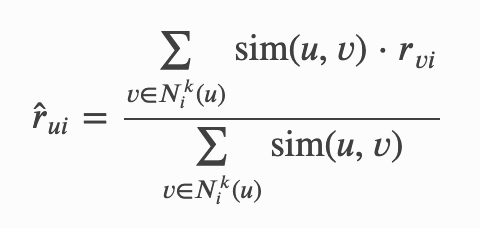

*Шаг 1:* Ищем K ближайших юзеров к целевому юзеру  
*Шаг 2*: predict "скора" товара = среднему "скору" этого товара у его соседей  
*Шаг 3*: Сортируем товары по убыванию predict-ов и берем топ-k

----
**(!) Важно** 
- У item-item алгоритмов большая сложность predict ($O(I^2 log(I))$ или $O(I^3)$, в зависимости от реализации 
- Если в датасете много item_id, то item-item модели ОЧЕНЬ долго предсказывают. Со всеми товарами predict на тесте ~2 часа
- Давайте возьмем из ~90к товаров только 5k самых популярных 

*P.S.*  Брать топ-Х популярных и рекомендовать только из них - очень популярная стратегия.   
*P.P.S.*  В рекомендательных системах много таких трюков. Что-то подобное в курсе вы увидите еще не раз

In [19]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

popularity.head()

item_id  n_sold
0  25671.0     1.0
1  26426.0     1.0
2  26540.0     2.0
3  26601.0     1.0
4  26691.0     3.0

In [20]:
top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [21]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id  202291.0    397896.0    420647.0    480014.0    818980.0    \
user_id                                                               
1               0.0         0.0         0.0         0.0         0.0   
2               0.0         0.0         0.0         0.0         0.0   
3               0.0         0.0         0.0         0.0         0.0   

item_id  818981.0    819063.0    819255.0    819302.0    819304.0    ...  \
user_id                                                              ...   
1               0.0         0.0         0.0         0.0         0.0  ...   
2               0.0         0.0         0.0         0.0         0.0  ...   
3               0.0         0.0         0.0         0.0         0.0  ...   

item_id  12302069.0  12349795.0  12351966.0  12384365.0  12384657.0  \
user_id                                                               
1               0.0         0.0         0.0         0.0         0.0   
2               1.0         0.0         0.0         0.0         0.0   
3               0.0         0.0         0.0         0.0         0.0   

item_id  12384775.0  12385340.0  12425418.0  12524245.0  12524690.0  
user_id                                                              
1               0.0         0.0         0.0         0.0         0.0  
2               0.0         0.0         1.0         0.0         0.0  
3               0.0         0.0         0.0         0.0         0.0  

[3 rows x 5001 columns]

In [22]:
user_item_matrix.shape

(2496, 5001)

In [23]:
user_item_matrix.sum().sum() / (user_item_matrix.shape[0] * user_item_matrix.shape[1]) * 100

2.0946852296207426

In [24]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [25]:
csr_matrix(user_item_matrix).T.tocsr()

<5001x2496 sparse matrix of type '<class 'numpy.float64'>'
	with 261469 stored elements in Compressed Sparse Row format>

In [ ]:
%%time

model = ItemItemRecommender(K=5, num_threads=12) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[1],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)

  0%|          | 0/2496 [00:00<?, ?it/s]

In [ ]:
recs

In [ ]:
[id_to_itemid[rec[0]] for rec in recs]

In [ ]:
%%time

result['itemitem'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)])

In [ ]:
result.head(2)

### 4.2 Косинусное сходство и CosineRecommender

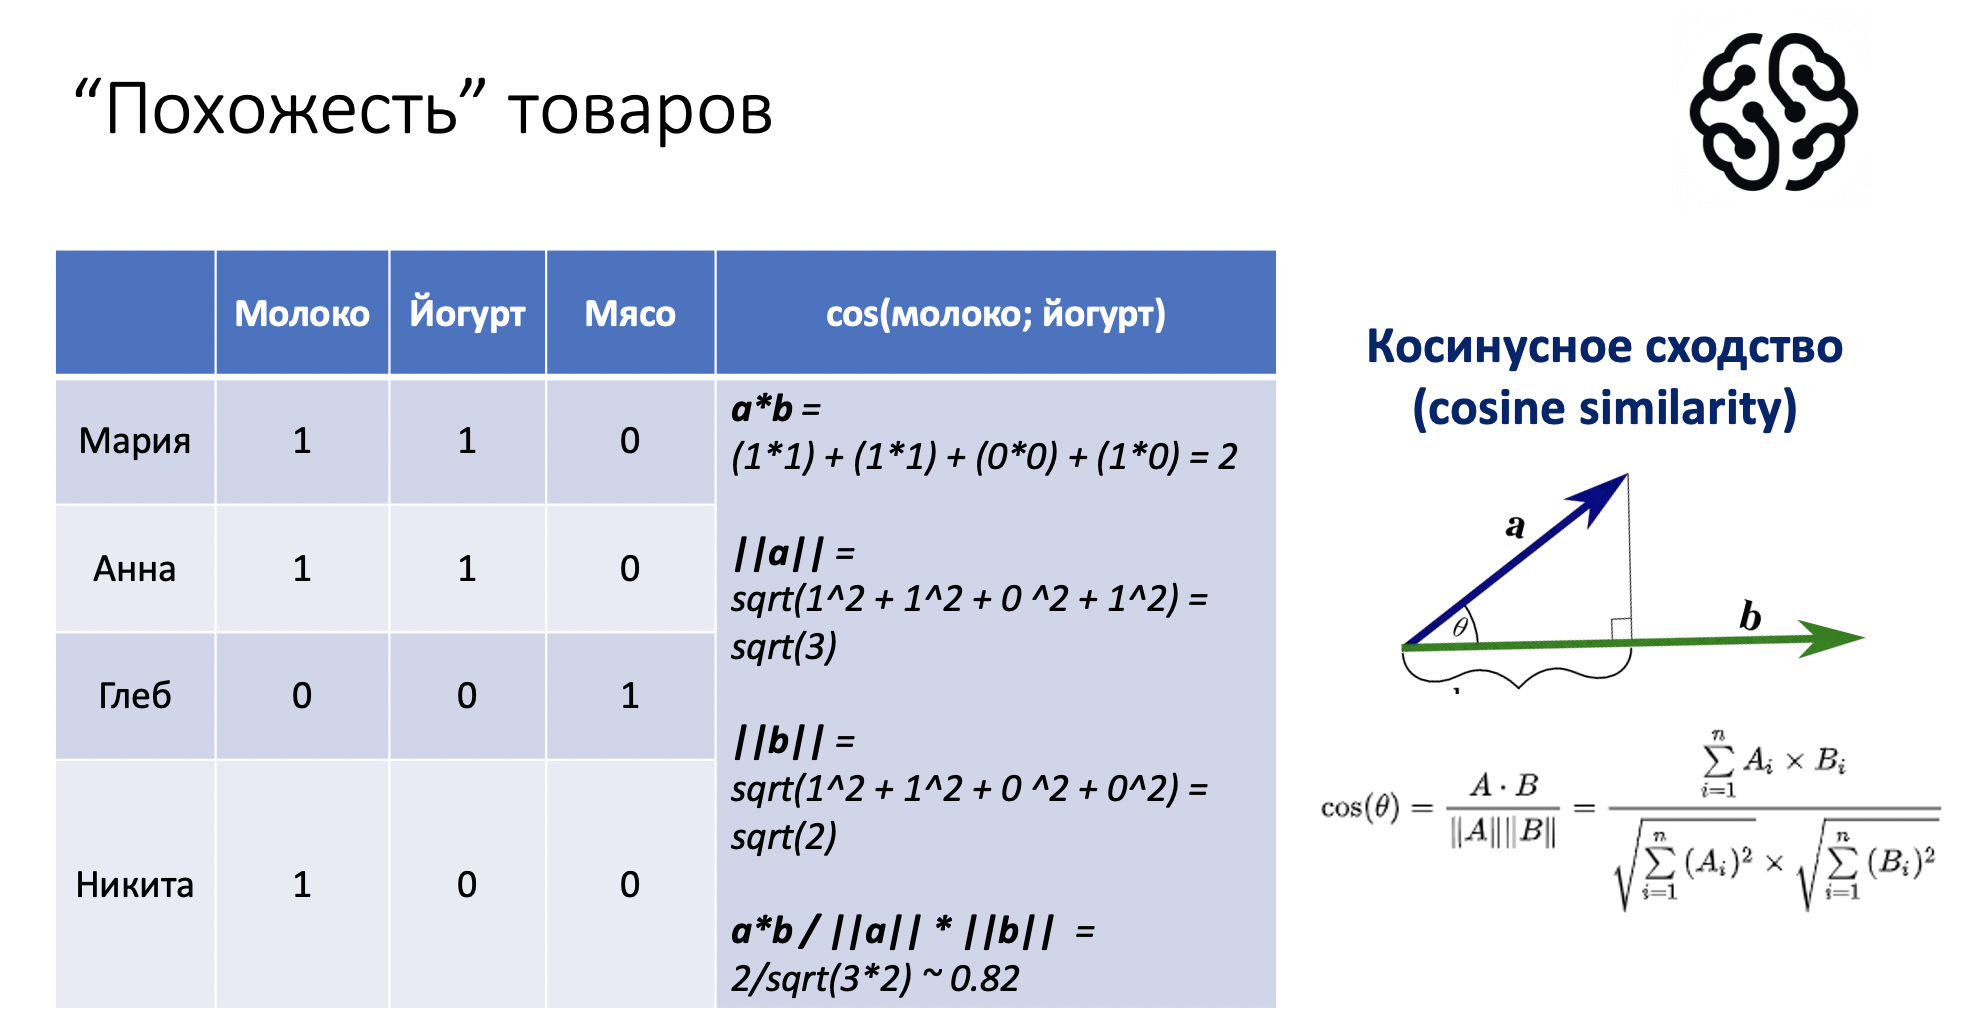

In [ ]:
%%time

model = CosineRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(), 
          show_progress=True)

recs = model.recommend(userid=userid_to_id[1], 
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=False)

In [ ]:
[id_to_itemid[round(rec[0])] for rec in recs]

In [ ]:
%%time

result['cosine'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)])

In [ ]:
result.head(2)

### 4.3 TF-IDF взвешивание и TFIDFRecommender

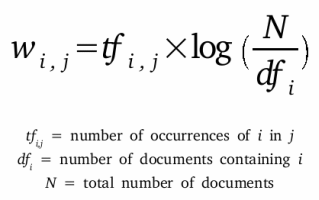

Если 2 юзера оба купили очень популярный товар, то это еще не значит,что они похожи   
Если 2 юзера оба купили редкий товар, то они похожи

Занижаем вес популярных товаров при расчете расстояний между пользователями

In [ ]:
%%time

model = TFIDFRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(), 
          show_progress=True)

recs = model.recommend(userid=userid_to_id[1], 
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=False)

In [ ]:
[id_to_itemid[rec[0]] for rec in recs]

In [ ]:
%%time

result['tfidf'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=False)])

In [ ]:
result.head(2)

### 4.4 Трюк

In [ ]:
%%time

model = ItemItemRecommender(K=1, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(), 
          show_progress=True)

recs = model.recommend(userid=userid_to_id[1], 
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=False)

In [ ]:
[id_to_itemid[rec[0]] for rec in recs]

In [ ]:
%%time

result['own_purchases'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[999999], 
                                    recalculate_user=False)])

### 4.5 Измерим качество по precision@5

In [ ]:
result.head(2)

In [ ]:
result.to_csv('../predictions/predictions_basic.csv', index=False)

Можно ли улучшить бейзлайны, если считать их на топ-5000 товарах?

In [ ]:
# your_code

In [ ]:
# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.metrics import precision_at_k, recall_at_k

In [ ]:
result.apply(lambda row: precision_at_k(row['random_recommendation'], row['actual']), axis=1).mean()

In [ ]:
result.apply(lambda row: precision_at_k(row['popular_recommendation'], row['actual']), axis=1).mean()

In [ ]:
result.apply(lambda row: precision_at_k(row['itemitem'], row['actual']), axis=1).mean()

In [ ]:
result.apply(lambda row: precision_at_k(row['cosine'], row['actual']), axis=1).mean()

In [ ]:
result.apply(lambda row: precision_at_k(row['tfidf'], row['actual']), axis=1).mean()

In [ ]:
result.apply(lambda row: precision_at_k(row['own_purchases'], row['actual']), axis=1).mean()